<a href="https://colab.research.google.com/github/Kira265/advances-self-supervised-models/blob/main/Advances_in_Self_supervised_Models_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install fvcore seaborn psutil

In [ ]:
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity

# Define a self-attention module with the smallest possible dimensions and precision
class SelfAttention(nn.Module):
    def __init__(self, d_model=4, nhead=1):  # Minimal dimensions
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)

    def forward(self, x):
        return self.attention(x, x, x)[0]

# Function to measure FLOPS, memory, and time with lowest possible settings
def profile_self_attention(input_length, d_model=4, nhead=1, device='cuda', dtype=torch.float16):
    model = SelfAttention(d_model, nhead).to(device, dtype=dtype)
    x = torch.randn((1, input_length, d_model), device=device, dtype=dtype)  # batch size of 1

    # Measure wall clock time
    start_time = time.time()
    with torch.no_grad():
        with record_function("self_attention_forward"):
            model(x)
    wall_clock_time = time.time() - start_time

    # Measure memory usage
    if device == 'cuda':
        torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            model(x)
        memory_usage = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB
    else:
        memory_usage = torch.cuda.memory_allocated(device) / (1024 ** 2)

    # Measure FLOPS
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        with torch.no_grad():
            with record_function("self_attention_forward"):
                model(x)
    flops = sum([event.cpu_time_total for event in prof.key_averages() if event.key == "self_attention_forward"])

    return flops, memory_usage, wall_clock_time

# Define input lengths and profile them with the lowest possible dimensions and precision
input_lengths = [10, 100, 1000, 10000]
flops_list, memory_list, time_list = [], [], []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for length in input_lengths:
    flops, memory, time_elapsed = profile_self_attention(input_length=length, device=device)
    flops_list.append(flops)
    memory_list.append(memory)
    time_list.append(time_elapsed)

# Plotting the results
def plot_trends(input_lengths, values, ylabel, title):
    plt.figure()
    plt.errorbar(input_lengths, values, yerr=np.std(values)/np.sqrt(len(values)), fmt='-o')
    plt.xscale('log')
    plt.xlabel('Input Length')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_trends(input_lengths, flops_list, 'FLOPS', 'FLOPS vs Input Length')
plot_trends(input_lengths, memory_list, 'Memory Usage (MB)', 'Memory Usage vs Input Length')
plot_trends(input_lengths, time_list, 'Wall Clock Time (s)', 'Wall Clock Time vs Input Length')

# Print Results
for i, length in enumerate(input_lengths):
    print(f"Input Length: {length} -> FLOPS: {flops_list[i]}, Memory Usage: {memory_list[i]} MB, Time: {time_list[i]} seconds")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Profiling on CPU...
Profiling sequence length: 10
Profiling sequence length: 100
Profiling sequence length: 1000
Profiling sequence length: 10000
Profiling sequence length: 100000


## 4.1 Build a Classifier

In [1]:
!pip install transformers datasets torch tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Check for CUDA availability
if torch.cuda.is_available():
    try:
        torch.cuda.init()
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    except RuntimeError:
        print("CUDA initialization failed. Falling back to CPU.")
        device = torch.device("cpu")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 50/4210 [00:17<24:36,  2.82it/s]

Step 50: Train Accuracy: 0.5659, Eval Accuracy: 0.5092


  2%|▏         | 100/4210 [00:53<24:18,  2.82it/s]

Step 100: Train Accuracy: 0.8898, Eval Accuracy: 0.8945


  4%|▎         | 150/4210 [01:28<23:58,  2.82it/s]

Step 150: Train Accuracy: 0.8705, Eval Accuracy: 0.8830


  5%|▍         | 200/4210 [02:03<23:40,  2.82it/s]

Step 200: Train Accuracy: 0.9091, Eval Accuracy: 0.9048


  6%|▌         | 250/4210 [02:38<23:22,  2.82it/s]

Step 250: Train Accuracy: 0.9011, Eval Accuracy: 0.9151


  7%|▋         | 300/4210 [03:13<23:05,  2.82it/s]

Step 300: Train Accuracy: 0.8795, Eval Accuracy: 0.8876


  8%|▊         | 350/4210 [03:49<22:49,  2.82it/s]

Step 350: Train Accuracy: 0.9045, Eval Accuracy: 0.9186


 10%|▉         | 400/4210 [04:24<22:29,  2.82it/s]

Step 400: Train Accuracy: 0.8943, Eval Accuracy: 0.8979


 11%|█         | 450/4210 [04:59<22:11,  2.82it/s]

Step 450: Train Accuracy: 0.9000, Eval Accuracy: 0.9083


 12%|█▏        | 500/4210 [05:34<21:53,  2.82it/s]

Step 500: Train Accuracy: 0.9023, Eval Accuracy: 0.8922


 13%|█▎        | 550/4210 [06:09<21:36,  2.82it/s]

Step 550: Train Accuracy: 0.9102, Eval Accuracy: 0.9186


 14%|█▍        | 600/4210 [06:44<21:19,  2.82it/s]

Step 600: Train Accuracy: 0.9170, Eval Accuracy: 0.9151


 15%|█▌        | 650/4210 [07:19<21:00,  2.82it/s]

Step 650: Train Accuracy: 0.9148, Eval Accuracy: 0.9163


 17%|█▋        | 700/4210 [07:55<20:44,  2.82it/s]

Step 700: Train Accuracy: 0.9148, Eval Accuracy: 0.9289


 18%|█▊        | 750/4210 [08:30<20:26,  2.82it/s]

Step 750: Train Accuracy: 0.9159, Eval Accuracy: 0.9151


 19%|█▉        | 800/4210 [09:05<20:09,  2.82it/s]

Step 800: Train Accuracy: 0.9011, Eval Accuracy: 0.9128


 20%|██        | 850/4210 [09:41<19:51,  2.82it/s]

Step 850: Train Accuracy: 0.9159, Eval Accuracy: 0.9174


 21%|██▏       | 900/4210 [10:16<19:33,  2.82it/s]

Step 900: Train Accuracy: 0.9170, Eval Accuracy: 0.9186


 23%|██▎       | 950/4210 [10:51<19:15,  2.82it/s]

Step 950: Train Accuracy: 0.9182, Eval Accuracy: 0.9220


 24%|██▍       | 1000/4210 [11:27<18:58,  2.82it/s]

Step 1000: Train Accuracy: 0.9193, Eval Accuracy: 0.9266


 25%|██▍       | 1050/4210 [12:02<18:40,  2.82it/s]

Step 1050: Train Accuracy: 0.9261, Eval Accuracy: 0.9186


 26%|██▌       | 1100/4210 [12:37<18:22,  2.82it/s]

Step 1100: Train Accuracy: 0.9318, Eval Accuracy: 0.9163


 27%|██▋       | 1150/4210 [13:13<18:05,  2.82it/s]

Step 1150: Train Accuracy: 0.9375, Eval Accuracy: 0.9197


 29%|██▊       | 1200/4210 [13:48<17:46,  2.82it/s]

Step 1200: Train Accuracy: 0.9318, Eval Accuracy: 0.9323


 30%|██▉       | 1250/4210 [14:23<17:28,  2.82it/s]

Step 1250: Train Accuracy: 0.9409, Eval Accuracy: 0.9197


 31%|███       | 1300/4210 [14:58<17:10,  2.82it/s]

Step 1300: Train Accuracy: 0.9284, Eval Accuracy: 0.9289


 32%|███▏      | 1350/4210 [15:34<16:53,  2.82it/s]

Step 1350: Train Accuracy: 0.9443, Eval Accuracy: 0.9220


 33%|███▎      | 1400/4210 [16:09<16:35,  2.82it/s]

Step 1400: Train Accuracy: 0.9318, Eval Accuracy: 0.9312


 34%|███▍      | 1450/4210 [16:44<16:18,  2.82it/s]

Step 1450: Train Accuracy: 0.9352, Eval Accuracy: 0.9278


 36%|███▌      | 1500/4210 [17:19<15:59,  2.82it/s]

Step 1500: Train Accuracy: 0.9420, Eval Accuracy: 0.9140


 37%|███▋      | 1550/4210 [17:54<15:44,  2.82it/s]

Step 1550: Train Accuracy: 0.9364, Eval Accuracy: 0.9266


 38%|███▊      | 1600/4210 [18:30<15:26,  2.82it/s]

Step 1600: Train Accuracy: 0.9182, Eval Accuracy: 0.9151


 39%|███▉      | 1650/4210 [19:05<15:08,  2.82it/s]

Step 1650: Train Accuracy: 0.9409, Eval Accuracy: 0.9232


 40%|████      | 1700/4210 [19:40<14:48,  2.82it/s]

Step 1700: Train Accuracy: 0.9307, Eval Accuracy: 0.9186


 42%|████▏     | 1750/4210 [20:15<14:31,  2.82it/s]

Step 1750: Train Accuracy: 0.9227, Eval Accuracy: 0.9278


 43%|████▎     | 1800/4210 [20:51<14:14,  2.82it/s]

Step 1800: Train Accuracy: 0.9432, Eval Accuracy: 0.9369


 44%|████▍     | 1850/4210 [21:26<13:56,  2.82it/s]

Step 1850: Train Accuracy: 0.9420, Eval Accuracy: 0.9278


 45%|████▌     | 1900/4210 [22:01<13:38,  2.82it/s]

Step 1900: Train Accuracy: 0.9466, Eval Accuracy: 0.9243


 46%|████▋     | 1950/4210 [22:37<13:21,  2.82it/s]

Step 1950: Train Accuracy: 0.9409, Eval Accuracy: 0.9300


 48%|████▊     | 2000/4210 [23:12<13:03,  2.82it/s]

Step 2000: Train Accuracy: 0.9307, Eval Accuracy: 0.9289


 49%|████▊     | 2050/4210 [23:48<12:45,  2.82it/s]

Step 2050: Train Accuracy: 0.9443, Eval Accuracy: 0.9278


 50%|████▉     | 2100/4210 [24:23<12:27,  2.82it/s]

Step 2100: Train Accuracy: 0.9398, Eval Accuracy: 0.9369


 51%|█████     | 2150/4210 [24:58<12:10,  2.82it/s]

Step 2150: Train Accuracy: 0.9432, Eval Accuracy: 0.9232


 52%|█████▏    | 2200/4210 [25:33<11:53,  2.82it/s]

Step 2200: Train Accuracy: 0.9534, Eval Accuracy: 0.9300


 53%|█████▎    | 2250/4210 [26:09<11:34,  2.82it/s]

Step 2250: Train Accuracy: 0.9432, Eval Accuracy: 0.9186


 55%|█████▍    | 2300/4210 [26:44<11:17,  2.82it/s]

Step 2300: Train Accuracy: 0.9545, Eval Accuracy: 0.9312


 56%|█████▌    | 2350/4210 [27:19<10:58,  2.82it/s]

Step 2350: Train Accuracy: 0.9614, Eval Accuracy: 0.9278


 57%|█████▋    | 2400/4210 [27:54<10:41,  2.82it/s]

Step 2400: Train Accuracy: 0.9477, Eval Accuracy: 0.9255


 58%|█████▊    | 2450/4210 [28:29<10:23,  2.82it/s]

Step 2450: Train Accuracy: 0.9557, Eval Accuracy: 0.9335


 59%|█████▉    | 2500/4210 [29:05<10:05,  2.82it/s]

Step 2500: Train Accuracy: 0.9500, Eval Accuracy: 0.9266


 61%|██████    | 2550/4210 [29:40<09:49,  2.82it/s]

Step 2550: Train Accuracy: 0.9545, Eval Accuracy: 0.9381


 62%|██████▏   | 2600/4210 [30:15<09:31,  2.82it/s]

Step 2600: Train Accuracy: 0.9568, Eval Accuracy: 0.9381


 63%|██████▎   | 2650/4210 [30:50<09:13,  2.82it/s]

Step 2650: Train Accuracy: 0.9455, Eval Accuracy: 0.9300


 64%|██████▍   | 2700/4210 [31:25<08:54,  2.82it/s]

Step 2700: Train Accuracy: 0.9545, Eval Accuracy: 0.9484


 65%|██████▌   | 2750/4210 [32:00<08:37,  2.82it/s]

Step 2750: Train Accuracy: 0.9489, Eval Accuracy: 0.9335


 67%|██████▋   | 2800/4210 [32:36<08:19,  2.82it/s]

Step 2800: Train Accuracy: 0.9568, Eval Accuracy: 0.9358


 68%|██████▊   | 2850/4210 [33:11<08:02,  2.82it/s]

Step 2850: Train Accuracy: 0.9330, Eval Accuracy: 0.9289


 69%|██████▉   | 2900/4210 [33:46<07:44,  2.82it/s]

Step 2900: Train Accuracy: 0.9568, Eval Accuracy: 0.9358


 70%|███████   | 2950/4210 [34:22<07:26,  2.82it/s]

Step 2950: Train Accuracy: 0.9420, Eval Accuracy: 0.9369


 71%|███████▏  | 3000/4210 [34:57<07:09,  2.82it/s]

Step 3000: Train Accuracy: 0.9625, Eval Accuracy: 0.9289


 72%|███████▏  | 3050/4210 [35:32<06:50,  2.82it/s]

Step 3050: Train Accuracy: 0.9580, Eval Accuracy: 0.9300


 74%|███████▎  | 3100/4210 [36:07<06:33,  2.82it/s]

Step 3100: Train Accuracy: 0.9409, Eval Accuracy: 0.9392


 75%|███████▍  | 3150/4210 [36:43<06:15,  2.82it/s]

Step 3150: Train Accuracy: 0.9602, Eval Accuracy: 0.9278


 76%|███████▌  | 3200/4210 [37:18<05:57,  2.82it/s]

Step 3200: Train Accuracy: 0.9614, Eval Accuracy: 0.9312


 77%|███████▋  | 3250/4210 [37:53<05:40,  2.82it/s]

Step 3250: Train Accuracy: 0.9386, Eval Accuracy: 0.9220


 78%|███████▊  | 3300/4210 [38:29<05:22,  2.82it/s]

Step 3300: Train Accuracy: 0.9591, Eval Accuracy: 0.9186


 80%|███████▉  | 3350/4210 [39:04<05:04,  2.82it/s]

Step 3350: Train Accuracy: 0.9591, Eval Accuracy: 0.9266


 81%|████████  | 3400/4210 [39:39<04:47,  2.82it/s]

Step 3400: Train Accuracy: 0.9511, Eval Accuracy: 0.9232


 82%|████████▏ | 3450/4210 [40:14<04:29,  2.82it/s]

Step 3450: Train Accuracy: 0.9534, Eval Accuracy: 0.9232


 83%|████████▎ | 3500/4210 [40:50<04:11,  2.82it/s]

Step 3500: Train Accuracy: 0.9500, Eval Accuracy: 0.9197


 84%|████████▍ | 3550/4210 [41:25<03:53,  2.82it/s]

Step 3550: Train Accuracy: 0.9477, Eval Accuracy: 0.9289


 86%|████████▌ | 3600/4210 [42:00<03:36,  2.82it/s]

Step 3600: Train Accuracy: 0.9489, Eval Accuracy: 0.9346


 87%|████████▋ | 3650/4210 [42:36<03:18,  2.82it/s]

Step 3650: Train Accuracy: 0.9545, Eval Accuracy: 0.9381


 88%|████████▊ | 3700/4210 [43:11<03:00,  2.82it/s]

Step 3700: Train Accuracy: 0.9477, Eval Accuracy: 0.9369


 89%|████████▉ | 3750/4210 [43:46<02:43,  2.82it/s]

Step 3750: Train Accuracy: 0.9636, Eval Accuracy: 0.9186


 90%|█████████ | 3800/4210 [44:21<02:25,  2.82it/s]

Step 3800: Train Accuracy: 0.9682, Eval Accuracy: 0.9381


 91%|█████████▏| 3850/4210 [44:56<02:07,  2.82it/s]

Step 3850: Train Accuracy: 0.9591, Eval Accuracy: 0.9255


 93%|█████████▎| 3900/4210 [45:31<01:49,  2.82it/s]

Step 3900: Train Accuracy: 0.9625, Eval Accuracy: 0.9358


 94%|█████████▍| 3950/4210 [46:07<01:32,  2.82it/s]

Step 3950: Train Accuracy: 0.9602, Eval Accuracy: 0.9369


 95%|█████████▌| 4000/4210 [46:42<01:14,  2.82it/s]

Step 4000: Train Accuracy: 0.9591, Eval Accuracy: 0.9232


 96%|█████████▌| 4050/4210 [47:17<00:56,  2.82it/s]

Step 4050: Train Accuracy: 0.9545, Eval Accuracy: 0.9358


 97%|█████████▋| 4100/4210 [47:52<00:38,  2.82it/s]

Step 4100: Train Accuracy: 0.9591, Eval Accuracy: 0.9346


 99%|█████████▊| 4150/4210 [48:27<00:21,  2.82it/s]

Step 4150: Train Accuracy: 0.9591, Eval Accuracy: 0.9266


100%|█████████▉| 4200/4210 [49:03<00:03,  2.82it/s]

Step 4200: Train Accuracy: 0.9602, Eval Accuracy: 0.9300


100%|██████████| 4210/4210 [49:23<00:00,  2.01it/s]

ValueError: x and y must have same first dimension, but have shapes (85,) and (84,)

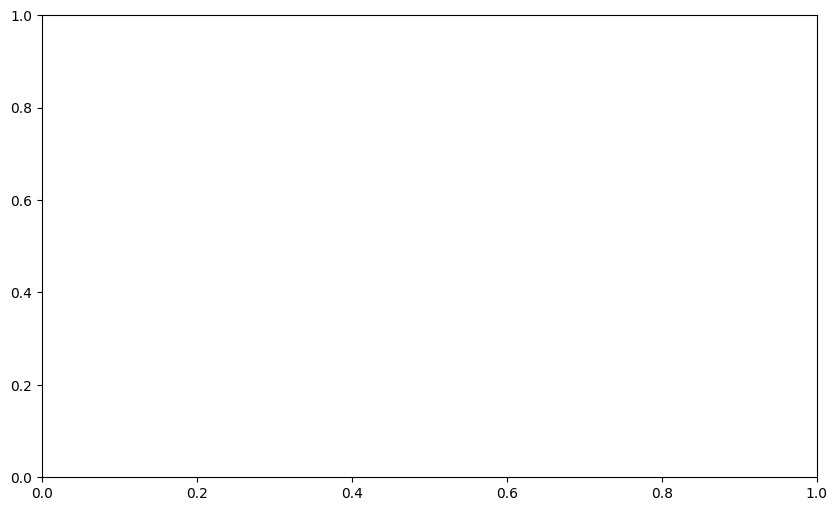

In [ ]:
# Load SST2 dataset
dataset = load_dataset("stanfordnlp/sst2")

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=16)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=16)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
eval_steps = 50

train_accuracies = []
eval_accuracies = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        # Evaluate every eval_steps
        if progress_bar.n % eval_steps == 0:
            model.eval()
            train_correct = 0
            train_total = 0
            eval_correct = 0
            eval_total = 0

            # Evaluate on a subset of training data
            for train_batch in list(train_dataloader)[:len(eval_dataloader)]:
                train_batch = {k: v.to(device) for k, v in train_batch.items()}
                with torch.no_grad():
                    outputs = model(**train_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                train_correct += (predictions == train_batch["labels"]).sum().item()
                train_total += train_batch["labels"].size(0)

            # Evaluate on validation set
            for eval_batch in eval_dataloader:
                eval_batch = {k: v.to(device) for k, v in eval_batch.items()}
                with torch.no_grad():
                    outputs = model(**eval_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                eval_correct += (predictions == eval_batch["labels"]).sum().item()
                eval_total += eval_batch["labels"].size(0)

            train_accuracy = train_correct / train_total
            eval_accuracy = eval_correct / eval_total

            train_accuracies.append(train_accuracy)
            eval_accuracies.append(eval_accuracy)

            print(f"Step {progress_bar.n}: Train Accuracy: {train_accuracy:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

            model.train()

In [ ]:
max(eval_accuracies)

0.948394495412844

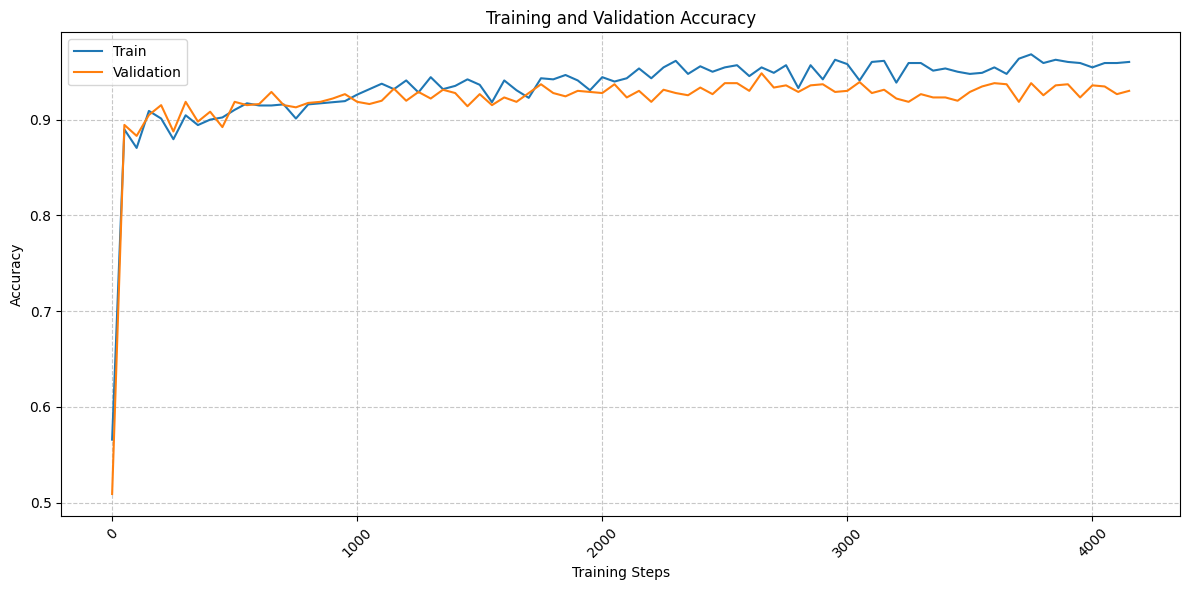

Plot saved as accuracy_plot.png


In [ ]:
num_points = len(train_accuracies)
steps = range(0, num_points * 50, 50)

plt.figure(figsize=(12, 6))
plt.plot(steps, train_accuracies, label="Train")
plt.plot(steps, eval_accuracies, label="Validation")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Improve x-axis readability
plt.xticks(rotation=45)

# Add some padding to the plot
plt.tight_layout()

# Save the plot
plt.savefig("accuracy_plot.png")
plt.show()  # This will display the plot if you're in an interactive environment

print("Plot saved as accuracy_plot.png")

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load SST2 dataset
dataset = load_dataset("stanfordnlp/sst2")

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Split the training set into new train and validation sets
train_val_data = tokenized_datasets["train"]
train_size = int(0.9 * len(train_val_data))
val_size = len(train_val_data) - train_size
new_train_dataset, new_val_dataset = random_split(train_val_data, [train_size, val_size])

# Prepare DataLoaders
train_dataloader = DataLoader(new_train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(new_val_dataset, batch_size=16)
test_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=16)  # Using original validation set as test set

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
eval_steps = 100  # Increased eval_steps

train_accuracies = []
eval_accuracies = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        # Evaluate every eval_steps
        if progress_bar.n % eval_steps == 0:
            model.eval()
            train_correct = 0
            train_total = 0
            eval_correct = 0
            eval_total = 0

            # Evaluate on a subset of training data
            for train_batch in list(train_dataloader)[:len(eval_dataloader)]:
                train_batch = {k: v.to(device) for k, v in train_batch.items()}
                with torch.no_grad():
                    outputs = model(**train_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                train_correct += (predictions == train_batch["labels"]).sum().item()
                train_total += train_batch["labels"].size(0)

            # Evaluate on new validation set
            for eval_batch in eval_dataloader:
                eval_batch = {k: v.to(device) for k, v in eval_batch.items()}
                with torch.no_grad():
                    outputs = model(**eval_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                eval_correct += (predictions == eval_batch["labels"]).sum().item()
                eval_total += eval_batch["labels"].size(0)

            train_accuracy = train_correct / train_total
            eval_accuracy = eval_correct / eval_total

            train_accuracies.append(train_accuracy)
            eval_accuracies.append(eval_accuracy)

            print(f"Step {progress_bar.n}: Train Accuracy: {train_accuracy:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

            model.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|          | 19/11367 [00:34<5:47:04,  1.84s/it]

  3%|▎         | 100/3789 [00:35<21:51,  2.81it/s]

Step 100: Train Accuracy: 0.8447, Eval Accuracy: 0.8486



  5%|▌         | 200/3789 [02:51<21:16,  2.81it/s]

Step 200: Train Accuracy: 0.9056, Eval Accuracy: 0.8986



  8%|▊         | 300/3789 [05:07<20:41,  2.81it/s]

Step 300: Train Accuracy: 0.8971, Eval Accuracy: 0.8927



 11%|█         | 400/3789 [07:22<20:06,  2.81it/s]

Step 400: Train Accuracy: 0.8928, Eval Accuracy: 0.8898



 13%|█▎        | 500/3789 [09:38<19:32,  2.81it/s]

Step 500: Train Accuracy: 0.9091, Eval Accuracy: 0.9085



 16%|█▌        | 600/3789 [11:54<18:54,  2.81it/s]

Step 600: Train Accuracy: 0.9145, Eval Accuracy: 0.9065



 18%|█▊        | 700/3789 [14:09<18:19,  2.81it/s]

Step 700: Train Accuracy: 0.9237, Eval Accuracy: 0.9122



 21%|██        | 800/3789 [16:25<17:43,  2.81it/s]

Step 800: Train Accuracy: 0.9111, Eval Accuracy: 0.9019



 24%|██▍       | 900/3789 [18:41<17:08,  2.81it/s]

Step 900: Train Accuracy: 0.8993, Eval Accuracy: 0.8973



 26%|██▋       | 1000/3789 [20:57<16:32,  2.81it/s]

Step 1000: Train Accuracy: 0.9299, Eval Accuracy: 0.9222



 29%|██▉       | 1100/3789 [23:13<15:56,  2.81it/s]

Step 1100: Train Accuracy: 0.9072, Eval Accuracy: 0.9045



 32%|███▏      | 1200/3789 [25:28<15:21,  2.81it/s]

Step 1200: Train Accuracy: 0.9326, Eval Accuracy: 0.9235



 34%|███▍      | 1300/3789 [27:44<14:44,  2.81it/s]

Step 1300: Train Accuracy: 0.9320, Eval Accuracy: 0.9219



 37%|███▋      | 1400/3789 [30:00<14:09,  2.81it/s]

Step 1400: Train Accuracy: 0.9322, Eval Accuracy: 0.9265



 40%|███▉      | 1500/3789 [32:16<13:34,  2.81it/s]

Step 1500: Train Accuracy: 0.9385, Eval Accuracy: 0.9258



 42%|████▏     | 1600/3789 [34:31<13:00,  2.81it/s]

Step 1600: Train Accuracy: 0.9439, Eval Accuracy: 0.9277



 45%|████▍     | 1700/3789 [36:47<12:21,  2.82it/s]

Step 1700: Train Accuracy: 0.9298, Eval Accuracy: 0.9210



 48%|████▊     | 1800/3789 [39:03<11:47,  2.81it/s]

Step 1800: Train Accuracy: 0.9437, Eval Accuracy: 0.9283



 50%|█████     | 1900/3789 [41:19<11:12,  2.81it/s]

Step 1900: Train Accuracy: 0.9374, Eval Accuracy: 0.9219



 53%|█████▎    | 2000/3789 [43:35<10:36,  2.81it/s]

Step 2000: Train Accuracy: 0.9431, Eval Accuracy: 0.9318



 55%|█████▌    | 2100/3789 [45:50<10:01,  2.81it/s]

Step 2100: Train Accuracy: 0.9500, Eval Accuracy: 0.9316



 58%|█████▊    | 2200/3789 [48:06<09:25,  2.81it/s]

Step 2200: Train Accuracy: 0.9304, Eval Accuracy: 0.9140



 61%|██████    | 2300/3789 [50:22<08:50,  2.81it/s]

Step 2300: Train Accuracy: 0.9449, Eval Accuracy: 0.9323



 63%|██████▎   | 2400/3789 [52:37<08:15,  2.80it/s]

Step 2400: Train Accuracy: 0.9509, Eval Accuracy: 0.9299



 66%|██████▌   | 2500/3789 [54:53<07:39,  2.81it/s]

Step 2500: Train Accuracy: 0.9515, Eval Accuracy: 0.9313



 69%|██████▊   | 2600/3789 [57:09<07:03,  2.81it/s]

Step 2600: Train Accuracy: 0.9480, Eval Accuracy: 0.9305



 71%|███████▏  | 2700/3789 [59:25<06:27,  2.81it/s]

Step 2700: Train Accuracy: 0.9390, Eval Accuracy: 0.9256



 74%|███████▍  | 2800/3789 [1:01:40<05:51,  2.81it/s]

Step 2800: Train Accuracy: 0.9546, Eval Accuracy: 0.9345



 77%|███████▋  | 2900/3789 [1:03:56<05:16,  2.81it/s]

Step 2900: Train Accuracy: 0.9433, Eval Accuracy: 0.9308



 79%|███████▉  | 3000/3789 [1:06:12<04:41,  2.81it/s]

Step 3000: Train Accuracy: 0.9584, Eval Accuracy: 0.9365



 82%|████████▏ | 3100/3789 [1:08:28<04:05,  2.80it/s]

Step 3100: Train Accuracy: 0.9509, Eval Accuracy: 0.9365



 84%|████████▍ | 3200/3789 [1:10:44<03:29,  2.81it/s]

Step 3200: Train Accuracy: 0.9567, Eval Accuracy: 0.9391



 87%|████████▋ | 3300/3789 [1:12:59<02:53,  2.81it/s]

Step 3300: Train Accuracy: 0.9434, Eval Accuracy: 0.9302



 90%|████████▉ | 3400/3789 [1:15:15<02:18,  2.81it/s]

Step 3400: Train Accuracy: 0.9556, Eval Accuracy: 0.9373



 92%|█████████▏| 3500/3789 [1:17:30<01:43,  2.80it/s]

Step 3500: Train Accuracy: 0.9522, Eval Accuracy: 0.9329



 95%|█████████▌| 3600/3789 [1:19:46<01:07,  2.82it/s]

Step 3600: Train Accuracy: 0.9627, Eval Accuracy: 0.9363



 98%|█████████▊| 3700/3789 [1:22:02<00:31,  2.81it/s]

Step 3700: Train Accuracy: 0.9565, Eval Accuracy: 0.9280



100%|██████████| 3789/3789 [1:24:14<00:00,  3.37it/s]

In [4]:
# Evaluate on the test set (original validation set)
model.eval()
test_correct = 0
test_total = 0

for test_batch in test_dataloader:
    test_batch = {k: v.to(device) for k, v in test_batch.items()}
    with torch.no_grad():
        outputs = model(**test_batch)
    predictions = torch.argmax(outputs.logits, dim=-1)
    test_correct += (predictions == test_batch["labels"]).sum().item()
    test_total += test_batch["labels"].size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9243


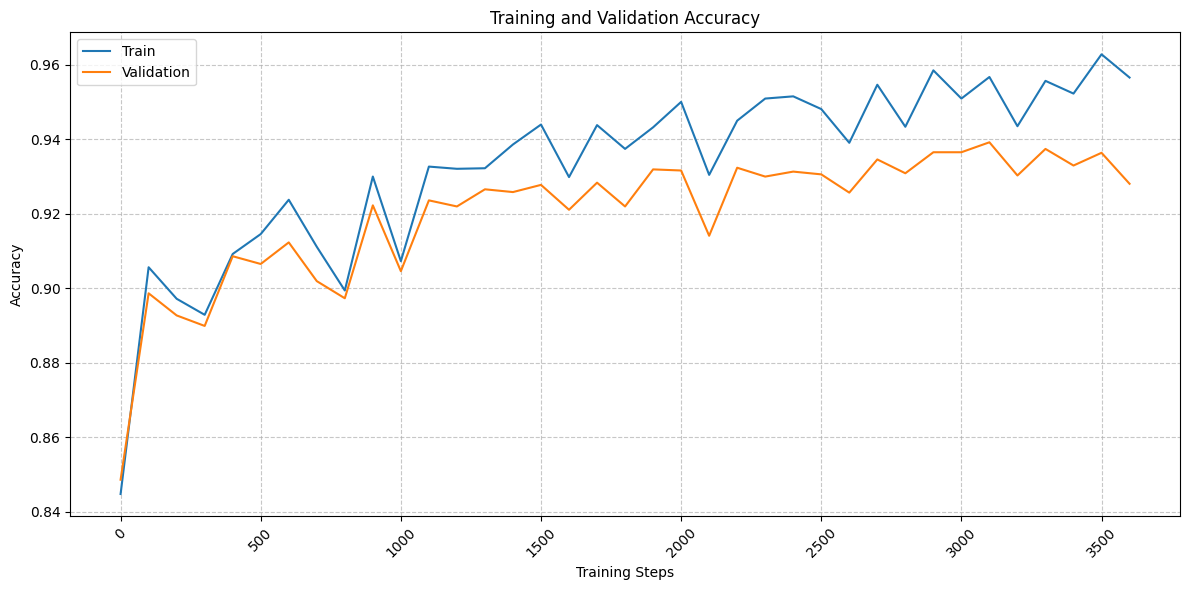

Plot saved as accuracy_plot.png


In [5]:
# Plotting
num_points = len(train_accuracies)
steps = range(0, num_points * eval_steps, eval_steps)

plt.figure(figsize=(12, 6))
plt.plot(steps, train_accuracies, label="Train")
plt.plot(steps, eval_accuracies, label="Validation")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("accuracy_plot.png")
plt.show()

print("Plot saved as accuracy_plot.png")

## 4.3 Building a LoRA Classifier

In [7]:
!pip install transformers datasets torch matplotlib tqdm peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 16.8 MB/s eta 0:00:00


In [8]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split

In [13]:
# Load SST2 dataset
dataset = load_dataset("stanfordnlp/sst2")

# Treat validation set as hold-out test set
test_dataset = dataset["validation"]

# Split training data into new train and validation sets
train_val_data = dataset["train"]
train_val_dict = train_val_data.train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_dict["train"]
val_dataset = train_val_dict["test"]

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

def tokenize_and_format(dataset):
    tokenized = dataset.map(tokenize_function, batched=True)
    tokenized = tokenized.remove_columns(["idx", "sentence"])
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")
    return tokenized

train_dataset = tokenize_and_format(train_dataset)
val_dataset = tokenize_and_format(val_dataset)
test_dataset = tokenize_and_format(test_dataset)

# Prepare DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Configure LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"]
)

# Get LoRA model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-4)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
eval_steps = 200

train_accuracies = []
eval_accuracies = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        # Evaluate every 200 eval_steps
        if progress_bar.n % eval_steps == 0:
            model.eval()
            train_correct = 0
            train_total = 0
            eval_correct = 0
            eval_total = 0

            # Evaluate on a subset of training data
            for train_batch in list(train_dataloader)[:len(eval_dataloader)]:
                train_batch = {k: v.to(device) for k, v in train_batch.items()}
                with torch.no_grad():
                    outputs = model(**train_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                train_correct += (predictions == train_batch["labels"]).sum().item()
                train_total += train_batch["labels"].size(0)

            # Evaluate on validation set
            for eval_batch in eval_dataloader:
                eval_batch = {k: v.to(device) for k, v in eval_batch.items()}
                with torch.no_grad():
                    outputs = model(**eval_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                eval_correct += (predictions == eval_batch["labels"]).sum().item()
                eval_total += eval_batch["labels"].size(0)

            train_accuracy = train_correct / train_total
            eval_accuracy = eval_correct / eval_total

            train_accuracies.append(train_accuracy)
            eval_accuracies.append(eval_accuracy)

            print(f"Step {progress_bar.n}: Train Accuracy: {train_accuracy:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
            print(f"Current loss: {loss.item():.4f}")

            model.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,034,498 || all params: 125,681,668 || trainable%: 0.8231



  8%|▊         | 600/7578 [21:50<4:13:55,  2.18s/it]

  3%|▎         | 201/7578 [02:40<65:09:17, 31.80s/it]

Step 200: Train Accuracy: 0.8998, Eval Accuracy: 0.8996
Current loss: 0.2630



  5%|▌         | 401/7578 [05:20<63:21:27, 31.78s/it]

Step 400: Train Accuracy: 0.9022, Eval Accuracy: 0.9035
Current loss: 0.3618



  8%|▊         | 601/7578 [08:00<61:45:43, 31.87s/it]

Step 600: Train Accuracy: 0.9200, Eval Accuracy: 0.9174
Current loss: 0.4080



 11%|█         | 801/7578 [10:40<59:45:56, 31.75s/it]

Step 800: Train Accuracy: 0.9093, Eval Accuracy: 0.9148
Current loss: 0.1376



 13%|█▎        | 1001/7578 [13:20<58:02:01, 31.77s/it]

Step 1000: Train Accuracy: 0.9212, Eval Accuracy: 0.9228
Current loss: 0.2617



 16%|█▌        | 1201/7578 [16:00<56:20:40, 31.81s/it]

Step 1200: Train Accuracy: 0.9262, Eval Accuracy: 0.9186
Current loss: 0.3095



 18%|█▊        | 1401/7578 [18:40<54:33:49, 31.80s/it]

Step 1400: Train Accuracy: 0.9274, Eval Accuracy: 0.9278
Current loss: 0.4056



 21%|██        | 1601/7578 [21:20<52:47:46, 31.80s/it]

Step 1600: Train Accuracy: 0.9258, Eval Accuracy: 0.9213
Current loss: 0.3053



 24%|██▍       | 1801/7578 [24:00<51:01:57, 31.80s/it]

Step 1800: Train Accuracy: 0.9186, Eval Accuracy: 0.9241
Current loss: 0.2702



 26%|██▋       | 2001/7578 [26:40<49:11:54, 31.76s/it]

Step 2000: Train Accuracy: 0.9181, Eval Accuracy: 0.9124
Current loss: 0.5561



 29%|██▉       | 2201/7578 [29:20<47:28:32, 31.79s/it]

Step 2200: Train Accuracy: 0.9256, Eval Accuracy: 0.9275
Current loss: 0.0752



 32%|███▏      | 2401/7578 [32:00<45:47:37, 31.84s/it]

Step 2400: Train Accuracy: 0.9284, Eval Accuracy: 0.9298
Current loss: 0.2592



 34%|███▍      | 2601/7578 [34:40<43:57:41, 31.80s/it]

Step 2600: Train Accuracy: 0.9332, Eval Accuracy: 0.9311
Current loss: 0.4642



 37%|███▋      | 2801/7578 [37:20<42:11:32, 31.80s/it]

Step 2800: Train Accuracy: 0.9313, Eval Accuracy: 0.9264
Current loss: 0.1322



 40%|███▉      | 3001/7578 [40:01<40:24:56, 31.79s/it]

Step 3000: Train Accuracy: 0.9302, Eval Accuracy: 0.9308
Current loss: 0.2611



 42%|████▏     | 3201/7578 [42:41<38:37:51, 31.77s/it]

Step 3200: Train Accuracy: 0.9333, Eval Accuracy: 0.9301
Current loss: 0.2500



 45%|████▍     | 3401/7578 [45:21<36:53:50, 31.80s/it]

Step 3400: Train Accuracy: 0.9366, Eval Accuracy: 0.9313
Current loss: 0.2488



 48%|████▊     | 3601/7578 [48:01<35:08:04, 31.80s/it]

Step 3600: Train Accuracy: 0.9366, Eval Accuracy: 0.9342
Current loss: 0.1140



 50%|█████     | 3801/7578 [50:41<33:20:06, 31.77s/it]

Step 3800: Train Accuracy: 0.9255, Eval Accuracy: 0.9286
Current loss: 0.2726



 53%|█████▎    | 4001/7578 [53:21<31:39:10, 31.86s/it]

Step 4000: Train Accuracy: 0.9344, Eval Accuracy: 0.9373
Current loss: 0.2774



 55%|█████▌    | 4201/7578 [56:01<29:49:57, 31.80s/it]

Step 4200: Train Accuracy: 0.9339, Eval Accuracy: 0.9284
Current loss: 0.1271



 58%|█████▊    | 4401/7578 [58:41<28:02:38, 31.78s/it]

Step 4400: Train Accuracy: 0.9387, Eval Accuracy: 0.9345
Current loss: 0.0661



 61%|██████    | 4601/7578 [1:01:21<26:17:27, 31.79s/it]

Step 4600: Train Accuracy: 0.9350, Eval Accuracy: 0.9299
Current loss: 0.1164



 63%|██████▎   | 4801/7578 [1:04:01<24:31:34, 31.79s/it]

Step 4800: Train Accuracy: 0.9311, Eval Accuracy: 0.9261
Current loss: 0.2493



 66%|██████▌   | 5001/7578 [1:06:41<22:44:55, 31.78s/it]

Step 5000: Train Accuracy: 0.9311, Eval Accuracy: 0.9310
Current loss: 0.1739



 69%|██████▊   | 5201/7578 [1:09:21<21:00:10, 31.81s/it]

Step 5200: Train Accuracy: 0.9339, Eval Accuracy: 0.9400
Current loss: 0.1194



 71%|███████▏  | 5401/7578 [1:12:01<19:12:29, 31.76s/it]

Step 5400: Train Accuracy: 0.9295, Eval Accuracy: 0.9278
Current loss: 0.1538



 74%|███████▍  | 5601/7578 [1:14:41<17:28:14, 31.81s/it]

Step 5600: Train Accuracy: 0.9363, Eval Accuracy: 0.9311
Current loss: 0.5362



 77%|███████▋  | 5801/7578 [1:17:21<15:41:09, 31.78s/it]

Step 5800: Train Accuracy: 0.9323, Eval Accuracy: 0.9347
Current loss: 0.1594



 79%|███████▉  | 6001/7578 [1:20:01<13:55:11, 31.78s/it]

Step 6000: Train Accuracy: 0.9365, Eval Accuracy: 0.9338
Current loss: 0.0982



 82%|████████▏ | 6201/7578 [1:22:41<12:09:09, 31.77s/it]

Step 6200: Train Accuracy: 0.9348, Eval Accuracy: 0.9353
Current loss: 0.1436



 84%|████████▍ | 6401/7578 [1:25:21<10:23:17, 31.77s/it]

Step 6400: Train Accuracy: 0.9375, Eval Accuracy: 0.9345
Current loss: 0.2708



 87%|████████▋ | 6601/7578 [1:28:01<8:37:36, 31.79s/it]

Step 6600: Train Accuracy: 0.9412, Eval Accuracy: 0.9284
Current loss: 0.1677



 90%|████████▉ | 6801/7578 [1:30:41<6:51:12, 31.75s/it]

Step 6800: Train Accuracy: 0.9507, Eval Accuracy: 0.9399
Current loss: 0.1481



 92%|█████████▏| 7001/7578 [1:33:21<5:05:24, 31.76s/it]

Step 7000: Train Accuracy: 0.9409, Eval Accuracy: 0.9370
Current loss: 0.1528



 95%|█████████▌| 7201/7578 [1:36:01<3:20:18, 31.88s/it]

Step 7200: Train Accuracy: 0.9423, Eval Accuracy: 0.9341
Current loss: 0.2694



 97%|█████████▋| 7388/7578 [1:36:53<00:52,  3.63it/s]

 98%|█████████▊| 7389/7578 [1:36:53<00:52,  3.63it/s]

 98%|█████████▊| 7390/7578 [1:36:53<00:51,  3.63it/s]

 98%|█████████▊| 7391/7578 [1:36:53<00:51,  3.64it/s]

 98%|█████████▊| 7392/7578 [1:36:54<00:51,  3.64it/s]

 98%|█████████▊| 7393/7578 [1:36:54<00:50,  3.63it/s]

 98%|█████████▊| 7394/7578 [1:36:54<00:50,  3.63it/s]

 98%|█████████▊| 7395/7578 [1:36:55<00:50,  3.63it/s]

 98%|█████████▊| 7396/7578 [1:36:55<00:50,  3.63it/s]

 98%|█████████▊| 7397/7578 [1:36:55<00:49,  3.63it/s]

 98%|█████████▊| 7398/7578 [1:36:55<00:49,  3.63it/s]

 98%|█████████▊| 7399/7578 [1:36:56<00:49,  3.63it/s]

 98%|█████████▊| 7400/7578 [1:36:56<00:48,  3.63it/s]

 98%|█████████▊| 7401/7578 [1:38:41<1:33:37, 31.74s/it]

Step 7400: Train Accuracy: 0.9360, Eval Accuracy: 0.9344
Current loss: 0.3211
Step 7400: Train Accuracy: 0.9360, Eval Accuracy: 0.9344
Current loss: 0.3211




 98%|█████████▊| 7402/7578 [1:38:41<1:05:24, 22.30s/it]

 98%|█████████▊| 7403/7578 [1:38:42<45:46, 15.69s/it]  

 98%|█████████▊| 7404/7578 [1:38:42<32:05, 11.07s/it]

 98%|█████████▊| 7405/7578 [1:38:42<22:34,  7.83s/it]

 98%|█████████▊| 7406/7578 [1:38:42<15:56,  5.56s/it]

 98%|█████████▊| 7407/7578 [1:38:43<11:20,  3.98s/it]

 98%|█████████▊| 7408/7578 [1:38:43<08:07,  2.87s/it]

 98%|█████████▊| 7409/7578 [1:38:43<05:52,  2.09s/it]

 98%|█████████▊| 7410/7578 [1:38:44<04:19,  1.54s/it]

 98%|█████████▊| 7411/7578 [1:38:44<03:14,  1.16s/it]

 98%|█████████▊| 7412/7578 [1:38:44<02:28,  1.11it/s]

 98%|█████████▊| 7413/7578 [1:38:44<01:57,  1.41it/s]

 98%|█████████▊| 7414/7578 [1:38:45<01:35,  1.72it/s]

 98%|█████████▊| 7415/7578 [1:38:45<01:19,  2.05it/s]

 98%|█████████▊| 7416/7578 [1:38:45<01:08,  2.36it/s]

 98%|█████████▊| 7417/7578 [1:38:46<01:01,  2.64it/s]

 98%|█████████▊| 7418/7578 [1:38:46<00:55,  2.87it/s]

 98%|█████████▊| 7419/7578 [1:38:46<00:51,  3.07it/s]

 98%

In [19]:
# Evaluate on the test set (original validation set)
model.eval()
test_correct = 0
test_total = 0

for test_batch in test_dataloader:
    test_batch = {k: v.to(device) for k, v in test_batch.items()}
    with torch.no_grad():
        outputs = model(**test_batch)
    predictions = torch.argmax(outputs.logits, dim=-1)
    test_correct += (predictions == test_batch["labels"]).sum().item()
    test_total += test_batch["labels"].size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9289


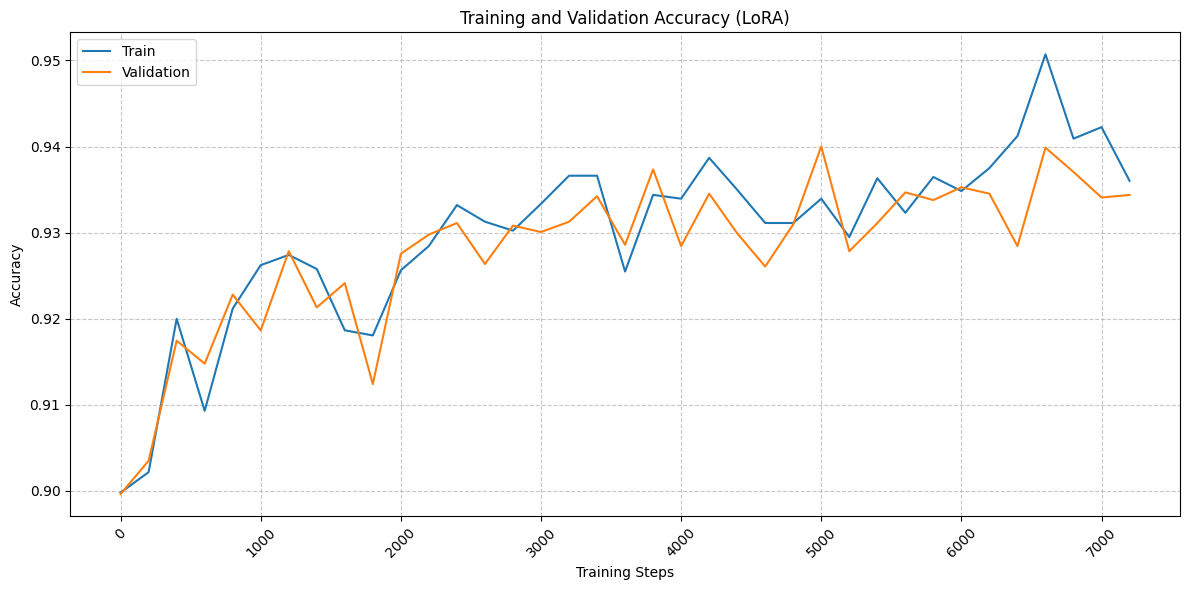

Plot saved as lora_accuracy_plot.png


In [21]:
# Plotting
num_points = len(train_accuracies)
steps = range(0, num_points * eval_steps, eval_steps)

plt.figure(figsize=(12, 6))
plt.plot(steps, train_accuracies, label="Train")
plt.plot(steps, eval_accuracies, label="Validation")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (LoRA)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("lora_accuracy_plot.png")
plt.show()

print("Plot saved as lora_accuracy_plot.png")

## Building a BitFit Classifier

In [22]:
!pip install transformers datasets torch tqdm matplotlib

In [23]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
# Load SST2 dataset
dataset = load_dataset("stanfordnlp/sst2")

# Treat validation set as hold-out test set
test_dataset = dataset["validation"]

# Split training data into new train and validation sets
train_val_data = dataset["train"]
train_val_dict = train_val_data.train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_dict["train"]
val_dataset = train_val_dict["test"]

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

def tokenize_and_format(dataset):
    tokenized = dataset.map(tokenize_function, batched=True)
    tokenized = tokenized.remove_columns(["idx", "sentence"])
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")
    return tokenized

train_dataset = tokenize_and_format(train_dataset)
val_dataset = tokenize_and_format(val_dataset)
test_dataset = tokenize_and_format(test_dataset)

# Prepare DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Implement BitFit: freeze all parameters except biases
for name, param in model.named_parameters():
    if 'bias' not in name:
        param.requires_grad = False

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} || All params: {all_params} || Trainable%: {100 * trainable_params / all_params:.2f}")

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-4)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
eval_steps = 100

train_accuracies = []
eval_accuracies = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        # Evaluate every 50 eval_steps
        if progress_bar.n % eval_steps == 0:
            model.eval()
            train_correct = 0
            train_total = 0
            eval_correct = 0
            eval_total = 0

            # Evaluate on a subset of training data
            for train_batch in list(train_dataloader)[:len(eval_dataloader)]:
                train_batch = {k: v.to(device) for k, v in train_batch.items()}
                with torch.no_grad():
                    outputs = model(**train_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                train_correct += (predictions == train_batch["labels"]).sum().item()
                train_total += train_batch["labels"].size(0)

            # Evaluate on validation set
            for eval_batch in eval_dataloader:
                eval_batch = {k: v.to(device) for k, v in eval_batch.items()}
                with torch.no_grad():
                    outputs = model(**eval_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                eval_correct += (predictions == eval_batch["labels"]).sum().item()
                eval_total += eval_batch["labels"].size(0)

            train_accuracy = train_correct / train_total
            eval_accuracy = eval_correct / eval_total

            train_accuracies.append(train_accuracy)
            eval_accuracies.append(eval_accuracy)

            print(f"Step {progress_bar.n}: Train Accuracy: {train_accuracy:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
            print(f"Current loss: {loss.item():.4f}")

            model.train()

Using the latest cached version of the dataset since stanfordnlp/sst2 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/stanfordnlp___sst2/default/0.0.0/8d51e7e4887a4caaa95b3fbebbf53c0490b58bbb (last modified on Fri Sep  6 14:50:23 2024).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 102914 || All params: 124647170 || Trainable%: 0.08



  2%|▏         | 103/4210 [02:25<1:36:59,  1.42s/it]

  3%|▎         | 101/3789 [00:43<5:27:46,  5.33s/it]

Step 100: Train Accuracy: 0.5489, Eval Accuracy: 0.5092
Current loss: 0.6785



  5%|▌         | 201/3789 [01:26<5:18:12,  5.32s/it]

Step 200: Train Accuracy: 0.5614, Eval Accuracy: 0.5092
Current loss: 0.7353



  8%|▊         | 301/3789 [02:09<5:07:46,  5.29s/it]

Step 300: Train Accuracy: 0.8398, Eval Accuracy: 0.8268
Current loss: 0.4094



 11%|█         | 401/3789 [02:53<5:03:53,  5.38s/it]

Step 400: Train Accuracy: 0.8932, Eval Accuracy: 0.8819
Current loss: 0.4680



 13%|█▎        | 501/3789 [03:36<4:50:38,  5.30s/it]

Step 500: Train Accuracy: 0.8989, Eval Accuracy: 0.9014
Current loss: 0.2010



 16%|█▌        | 601/3789 [04:19<4:42:07,  5.31s/it]

Step 600: Train Accuracy: 0.8898, Eval Accuracy: 0.8956
Current loss: 0.2873



 19%|█▊        | 701/3789 [05:03<4:33:35,  5.32s/it]

Step 700: Train Accuracy: 0.8966, Eval Accuracy: 0.9037
Current loss: 0.4214



 21%|██        | 801/3789 [05:46<4:24:42,  5.32s/it]

Step 800: Train Accuracy: 0.8898, Eval Accuracy: 0.9048
Current loss: 0.5554



 24%|██▍       | 901/3789 [06:29<4:16:12,  5.32s/it]

Step 900: Train Accuracy: 0.8886, Eval Accuracy: 0.9037
Current loss: 0.4383



 26%|██▋       | 1001/3789 [07:12<4:06:42,  5.31s/it]

Step 1000: Train Accuracy: 0.8932, Eval Accuracy: 0.9037
Current loss: 0.1337



 29%|██▉       | 1101/3789 [07:56<3:58:02,  5.31s/it]

Step 1100: Train Accuracy: 0.9102, Eval Accuracy: 0.9106
Current loss: 0.3047



 32%|███▏      | 1201/3789 [08:39<3:50:48,  5.35s/it]

Step 1200: Train Accuracy: 0.9125, Eval Accuracy: 0.9048
Current loss: 0.6223



 34%|███▍      | 1301/3789 [09:22<3:39:09,  5.29s/it]

Step 1300: Train Accuracy: 0.9000, Eval Accuracy: 0.9025
Current loss: 0.2625



 37%|███▋      | 1401/3789 [10:05<3:30:34,  5.29s/it]

Step 1400: Train Accuracy: 0.9091, Eval Accuracy: 0.9140
Current loss: 0.5647



 40%|███▉      | 1501/3789 [10:49<3:22:55,  5.32s/it]

Step 1500: Train Accuracy: 0.9170, Eval Accuracy: 0.9117
Current loss: 0.3081



 42%|████▏     | 1601/3789 [11:32<3:13:08,  5.30s/it]

Step 1600: Train Accuracy: 0.9023, Eval Accuracy: 0.9014
Current loss: 0.1241



 45%|████▍     | 1701/3789 [12:15<3:04:15,  5.29s/it]

Step 1700: Train Accuracy: 0.8875, Eval Accuracy: 0.9060
Current loss: 0.1871



 48%|████▊     | 1801/3789 [12:58<2:56:02,  5.31s/it]

Step 1800: Train Accuracy: 0.9023, Eval Accuracy: 0.9209
Current loss: 0.3488



 50%|█████     | 1901/3789 [13:41<2:46:49,  5.30s/it]

Step 1900: Train Accuracy: 0.9080, Eval Accuracy: 0.9197
Current loss: 0.3410



 53%|█████▎    | 2001/3789 [14:25<2:40:18,  5.38s/it]

Step 2000: Train Accuracy: 0.8943, Eval Accuracy: 0.9220
Current loss: 0.2602



 55%|█████▌    | 2101/3789 [15:08<2:29:13,  5.30s/it]

Step 2100: Train Accuracy: 0.9057, Eval Accuracy: 0.9128
Current loss: 0.1900



 58%|█████▊    | 2201/3789 [15:51<2:20:08,  5.29s/it]

Step 2200: Train Accuracy: 0.9386, Eval Accuracy: 0.9209
Current loss: 0.1693



 61%|██████    | 2301/3789 [16:34<2:11:29,  5.30s/it]

Step 2300: Train Accuracy: 0.8932, Eval Accuracy: 0.9060
Current loss: 0.4685



 63%|██████▎   | 2401/3789 [17:18<2:03:04,  5.32s/it]

Step 2400: Train Accuracy: 0.8886, Eval Accuracy: 0.9140
Current loss: 0.2106



 66%|██████▌   | 2501/3789 [18:01<1:53:37,  5.29s/it]

Step 2500: Train Accuracy: 0.8932, Eval Accuracy: 0.9083
Current loss: 0.3564



 69%|██████▊   | 2601/3789 [18:44<1:44:39,  5.29s/it]

Step 2600: Train Accuracy: 0.9307, Eval Accuracy: 0.9128
Current loss: 0.4017



 71%|███████▏  | 2701/3789 [19:27<1:36:02,  5.30s/it]

Step 2700: Train Accuracy: 0.9216, Eval Accuracy: 0.9151
Current loss: 0.3418



 74%|███████▍  | 2801/3789 [20:11<1:28:23,  5.37s/it]

Step 2800: Train Accuracy: 0.9148, Eval Accuracy: 0.9151
Current loss: 0.0924



 77%|███████▋  | 2901/3789 [20:54<1:18:47,  5.32s/it]

Step 2900: Train Accuracy: 0.9216, Eval Accuracy: 0.9266
Current loss: 0.2802



 79%|███████▉  | 3001/3789 [21:37<1:09:28,  5.29s/it]

Step 3000: Train Accuracy: 0.9125, Eval Accuracy: 0.9266
Current loss: 0.2695



 82%|████████▏ | 3101/3789 [22:20<1:00:33,  5.28s/it]

Step 3100: Train Accuracy: 0.9034, Eval Accuracy: 0.9266
Current loss: 0.2509



 84%|████████▍ | 3201/3789 [23:03<51:54,  5.30s/it]

Step 3200: Train Accuracy: 0.9080, Eval Accuracy: 0.9289
Current loss: 0.1524



 87%|████████▋ | 3301/3789 [23:47<43:16,  5.32s/it]

Step 3300: Train Accuracy: 0.9193, Eval Accuracy: 0.9312
Current loss: 0.3696



 90%|████████▉ | 3401/3789 [24:30<34:22,  5.31s/it]

Step 3400: Train Accuracy: 0.9159, Eval Accuracy: 0.9243
Current loss: 0.0669



 92%|█████████▏| 3501/3789 [25:13<25:32,  5.32s/it]

Step 3500: Train Accuracy: 0.9170, Eval Accuracy: 0.9243
Current loss: 0.5408



 95%|█████████▌| 3601/3789 [25:57<16:48,  5.37s/it]

Step 3600: Train Accuracy: 0.9068, Eval Accuracy: 0.9232
Current loss: 0.2800



 98%|█████████▊| 3701/3789 [26:40<07:46,  5.30s/it]

Step 3700: Train Accuracy: 0.9182, Eval Accuracy: 0.9243
Current loss: 0.4054



100%|██████████| 3789/3789 [27:03<00:00,  4.26it/s]

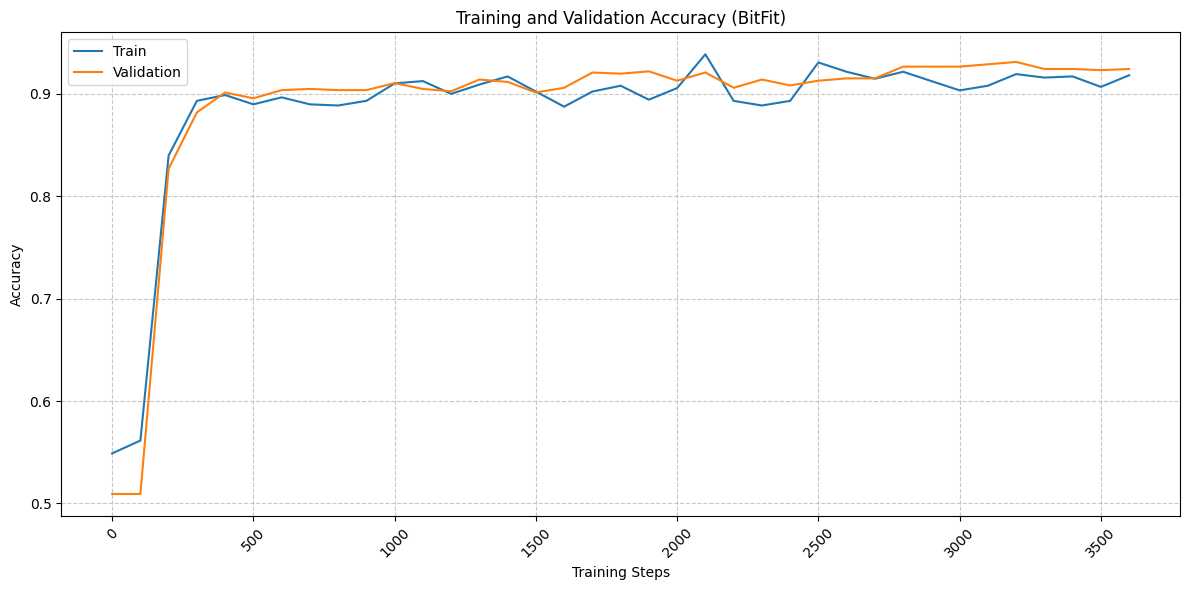

Plot saved as bitfit_accuracy_plot.png


In [26]:
# Plotting
num_points = len(train_accuracies)
steps = range(0, num_points * eval_steps, eval_steps)

plt.figure(figsize=(12, 6))
plt.plot(steps, train_accuracies, label="Train")
plt.plot(steps, eval_accuracies, label="Validation")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (BitFit)")
plt.legend()

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Improve x-axis readability
plt.xticks(rotation=45)

# Add some padding to the plot
plt.tight_layout()

# Save the plot
plt.savefig("bitfit_accuracy_plot.png")
plt.show()

print("Plot saved as bitfit_accuracy_plot.png")

In [27]:
max(eval_accuracies)

0.9311926605504587

In [28]:
# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        test_correct += (predictions == batch["labels"]).sum().item()
        test_total += batch["labels"].size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9278


In [ ]:
# Save the model
torch.save(model.state_dict(), "bitfit_sst2_model.pth")
print("Model saved as bitfit_sst2_model.pth")

## 5.2 Using OpenAI embeddings for retrieval

In [ ]:
!pip install faiss-cpu pickle5 datasets

In [ ]:
import pickle
import numpy as np

# Load document embeddings
with open('/content/scifact_evidence_embeddings.pkl', 'rb') as f:
    document_embeddings = pickle.load(f)

# Load claim embeddings
with open('/content/scifact_claim_embeddings.pkl', 'rb') as f:
    claim_embeddings = pickle.load(f)

In [ ]:
# Build the FAISS Index
import faiss

# Convert embeddings to numpy array
document_embeddings_np = np.array([embedding for embedding in document_embeddings.values()])

# Create the FAISS index
dimension = document_embeddings_np.shape[1]  # Assuming all embeddings have the same dimension
index = faiss.IndexFlatL2(dimension)  # Use L2 distance
index.add(document_embeddings_np)

In [ ]:
# Perform Retrieval
def retrieve_documents(claim_embedding, k=10):
    D, I = index.search(np.array([claim_embedding]), k)
    return I[0], D[0]  # Return indices and distances

# Example: Retrieve documents for the first claim
claim_id = list(claim_embeddings.keys())[0]
claim_embedding = claim_embeddings[claim_id]
retrieved_doc_ids, distances = retrieve_documents(claim_embedding)
print(retrieved_doc_ids)

[ 766 4032 2963 4132  166 4429 4368 4908 1373 2321]


In [ ]:
# Load the SciFact Dataset and Parse Gold Retrieval IDs
from datasets import load_dataset

# Load the claims part of the dataset
claims = load_dataset("allenai/scifact", "claims")

# Build a dictionary mapping each claim ID to its cited document IDs
gold_retrievals = {}
for claim in claims['train']:
    claim_id = claim['id']
    evidence_ids = claim['cited_doc_ids']  # Use 'cited_doc_ids' to get the evidence document IDs
    gold_retrievals[claim_id] = evidence_ids

In [ ]:
# Calculate MAP and MRR
def calculate_map_mrr(retrieved_ids, gold_ids, k=10):
    map_score = 0.0
    mrr_score = 0.0
    relevant_docs_found = 0

    for rank, doc_id in enumerate(retrieved_ids[:k], start=1):
        if doc_id in gold_ids:
            relevant_docs_found += 1
            precision_at_rank = relevant_docs_found / rank
            map_score += precision_at_rank
            if mrr_score == 0:
                mrr_score = 1 / rank

    if relevant_docs_found > 0:
        map_score /= relevant_docs_found

    return map_score, mrr_score

In [ ]:
# Evaluate and Summarize Results in a Table
import pandas as pd

results = []
for claim_key, claim_embedding in claim_embeddings.items():
    claim_id = claim_key[0]  # Extract the actual claim ID from the tuple key
    retrieved_doc_ids, _ = retrieve_documents(claim_embedding, k=10)
    gold_ids = gold_retrievals[claim_id]  # Match the claim ID with the correct gold IDs
    map_score, mrr_score = calculate_map_mrr(retrieved_doc_ids, gold_ids, k=10)
    results.append({'Claim ID': claim_id, 'MAP@10': map_score, 'MRR@10': mrr_score})

results_df = pd.DataFrame(results)
print(results_df)

     Claim ID  MAP@10  MRR@10
0           0     0.0     0.0
1           2     0.0     0.0
2           4     0.0     0.0
3           6     0.0     0.0
4           9     0.0     0.0
..        ...     ...     ...
804      1403     0.0     0.0
805      1404     0.0     0.0
806      1405     0.0     0.0
807      1406     0.0     0.0
808      1407     0.0     0.0

[809 rows x 3 columns]


## 5.3 Evaluating the IR System

In [ ]:
!pip install elasticsearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.3/523.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
from elasticsearch import Elasticsearch

In [ ]:
# Connect to Elasticsearch
es = Elasticsearch("http://127.0.0.1:9200")

# Check if Elasticsearch is running
if not es.ping():
    raise ValueError("Connection failed")

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 342, in perform_request
    resp = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 202, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5048daaa0>: Failed to establish a new connection: [Errno 111] Connection refused)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 342, in perform_request
    resp = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 202, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5048dac2

ValueError: Connection failed

In [ ]:
import json
from datasets import load_dataset

# Load the SciFact dataset, focusing on the corpus (evidence documents)
corpus = load_dataset("allenai/scifact", "corpus")

# Index documents in Elasticsearch
for doc in corpus['train']:
    doc_id = doc['doc_id']
    doc_text = doc['title'] + " " + doc['abstract']
    es.index(index='scifact_documents', id=doc_id, body={'text': doc_text})

In [ ]:
# Define a function to perform the search
def search_claim(claim_text):
    response = es.search(index='scifact_documents', body={
        "query": {
            "match": {
                "text": claim_text
            }
        }
    })

    return response['hits']['hits']


In [ ]:
# Example: Search for a specific claim
claim_example = "0-dimensional biomaterials lack inductive properties."
results = search_claim(claim_example)

# Print search results
for hit in results:
    print(f"Document ID: {hit['_id']}, Score: {hit['_score']}")
    print(f"Document: {hit['_source']['text']}\n")

In [ ]:
def calculate_map_mrr_es(results, gold_ids, k=10):
    map_score = 0.0
    mrr_score = 0.0
    relevant_docs_found = 0

    for rank, result in enumerate(results[:k], start=1):
        doc_id = int(result['_id'])
        if doc_id in gold_ids:
            relevant_docs_found += 1
            precision_at_rank = relevant_docs_found / rank
            map_score += precision_at_rank
            if mrr_score == 0:
                mrr_score = 1 / rank

    if relevant_docs_found > 0:
        map_score /= relevant_docs_found

    return map_score, mrr_score

In [ ]:
# Evaluate for all claims
evaluation_results = []
for claim in claims['train']:
    claim_id = claim['id']
    claim_text = claim['claim']
    gold_ids = claim['cited_doc_ids']

    # Retrieve documents using Elasticsearch
    search_results = search_claim(claim_text)

    # Calculate MAP and MRR
    map_score, mrr_score = calculate_map_mrr_es(search_results, gold_ids, k=10)
    evaluation_results.append({'Claim ID': claim_id, 'MAP@10': map_score, 'MRR@10': mrr_score})

In [ ]:
# Convert results to a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)